## Trabajo practico 2 Criticas 

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score, make_scorer)
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
np.random.seed(1)
tf.random.set_seed(1) 
from sklearn.preprocessing import StandardScaler

import nltk
import string

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('train.csv')

Analisis y preprocesamiento

In [3]:
df_train.head(5)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [4]:
df_train.dtypes

ID              int64
review_es      object
sentimiento    object
dtype: object

Pasamos los obejects a string 

Verificamos si el dataset tiene datos faltantes

In [5]:
datos_faltantes = df_train.isnull().sum()
print(datos_faltantes)

ID             0
review_es      0
sentimiento    0
dtype: int64


Observamos la distibucion de nustro target

In [6]:
df_train['sentimiento'].value_counts()

sentimiento
positivo    25000
negativo    25000
Name: count, dtype: int64

Realizamos un bag of words para poder utilizar los modelos

# PREPROCESAMIENTO

In [7]:
# Con nltk vamos a pasar a lowercase, tokenizar y extraer palabras conectoras del dataset.
def nltk_preprocess(text):
    global stop_words
    text = text.replace('.', '. ')
    text = text.lower()
    tokens = text.split()
    tokens = [word.strip(string.punctuation) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [8]:
#Primero, pasamos todo a minusculas.
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Franco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df_train["review_es"] = df_train["review_es"].apply(lambda x: nltk_preprocess(x))
df_train['review_es'] = df_train['review_es'].astype('string')
df_train['sentimiento'] = df_train['sentimiento'].astype('string')

In [10]:
# Creamos una variable con el sentimiento
# Convertimos a binaria
df_train['sentimiento_1'] = np.where(df_train['sentimiento'] == 'positivo', 1, 0)

In [11]:
df_copy_id = df_train['ID']
df_train.drop(columns = (['sentimiento','ID']))

,review_es,sentimiento_1
0,críticos mencionado después ver solo 1 oz epis...,1
1,pequeña pequeña producción técnica filmación i...,1
2,pensé manera maravillosa pasar tiempo fin sema...,1
3,básicamente familia niño pequeño jake piensa z...,0
4,amor tiempo petter mattei película visualmente...,1
...,...,...
49995,pensé película hizo buen trabajo derecha tan c...,1
49996,mala parcela mal diálogo mala actuación direcc...,0
49997,católica enseñada escuelas primarias parroquia...,0
49998,voy tener desacuerdo comentario anterior lado ...,0


## Bayes Naive

Dividimos nuestro Dataset en un conjunto de train y otro de test

In [12]:
#Creo un dataset con los features que voy a usar para clasificar
df_train_x = df_train['review_es']

#Creo un dataset con la variable target
df_train_y = df_train['sentimiento_1'].copy()

#Genero los conjuntos de train y test
x_train, x_test, y_train, y_test = train_test_split(df_train_x, 
                                                    df_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2,
                                                    stratify=df_train_y.values) #semilla

In [13]:
#Realizamos un TfidVectorizer para pasar tokenizar nuestras criticas
pipe = make_pipeline(TfidfVectorizer(), MultinomialNB()) #Usamos un make_pipe para pasarle la entrada al segundo modelo

param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 2)],  # Uni-gram or bi-gram
    'multinomialnb__alpha': [0.1],  # Smoothing parameter
}

# Grid search
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
display(best_params)
display(best_score)

{'multinomialnb__alpha': 0.1, 'tfidfvectorizer__ngram_range': (1, 2)}

0.878715842554063

In [14]:
nb_model = grid_search.best_estimator_

In [15]:
y_pred = nb_model.predict(x_test)
print(y_pred)

[0 0 0 ... 0 1 1]


Creamos una funcion para graficar la matriz de confusion y graficamos

In [13]:
def metricas(y_pred,y_test):

  print(classification_report(y_pred,y_test))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7469
           1       0.88      0.88      0.88      7531

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



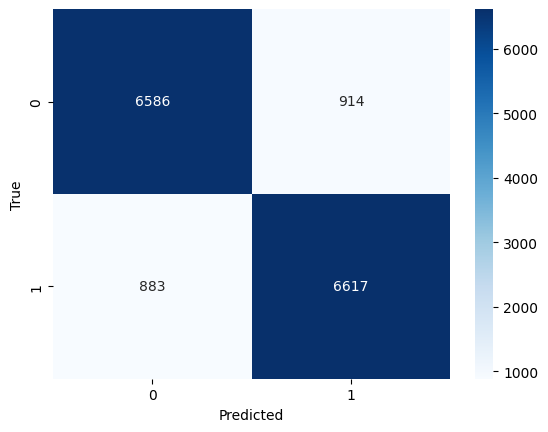

In [17]:
metricas(y_pred,y_test)

## Xg-boost

In [28]:
import xgboost as xg_boost

"""pipe = make_pipeline(TfidfVectorizer(), xg_boost.XGBClassifier())

param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # Uni-gram or bi-gram
    'xgbclassifier__max_depth': [3, 5, 7],  # Maximum depth of trees
    'xgbclassifier__learning_rate': [0.1, 0.2, 0.3],  # Learning rate
    'xgbclassifier__n_estimators': [100, 200, 300]  # Number of trees (boosting rounds)
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
display(best_params)
display(best_score)"""

"pipe = make_pipeline(TfidfVectorizer(), xg_boost.XGBClassifier())\n\nparam_grid = {\n    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],  # Uni-gram or bi-gram\n    'xgbclassifier__max_depth': [3, 5, 7],  # Maximum depth of trees\n    'xgbclassifier__learning_rate': [0.1, 0.2, 0.3],  # Learning rate\n    'xgbclassifier__n_estimators': [100, 200, 300]  # Number of trees (boosting rounds)\n}\n\ngrid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='f1')\ngrid_search.fit(x_train, y_train)\nbest_params = grid_search.best_params_\nbest_score = grid_search.best_score_\ndisplay(best_params)\ndisplay(best_score)"

In [29]:
xg_model = make_pipeline(TfidfVectorizer(), xg_boost.XGBClassifier(n_estimators=100, random_state = 0))
xg_model.fit(x_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

In [30]:
y_pred_Xg = xg_model.predict(x_test)

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      7085
           1       0.86      0.82      0.84      7915

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



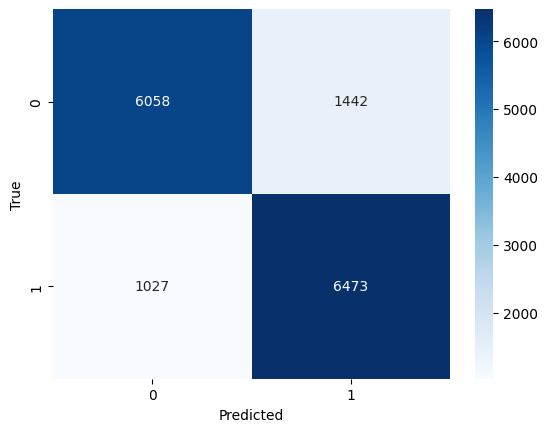

In [31]:
metricas(y_pred_Xg,y_test)

## Random Forest

In [18]:
#Creamos el modelo
vect = TfidfVectorizer(smooth_idf= True)
R_f = make_pipeline(vect, RandomForestClassifier()) #Tokenizamos el texto

In [19]:
#Entrenamos el modelo
R_f.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('randomforestclassifier', RandomForestClassifier())])

In [20]:
y_pred_R_M = R_f.predict(x_test)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      7642
           1       0.83      0.85      0.84      7358

    accuracy                           0.84     15000
   macro avg       0.84      0.84      0.84     15000
weighted avg       0.84      0.84      0.84     15000



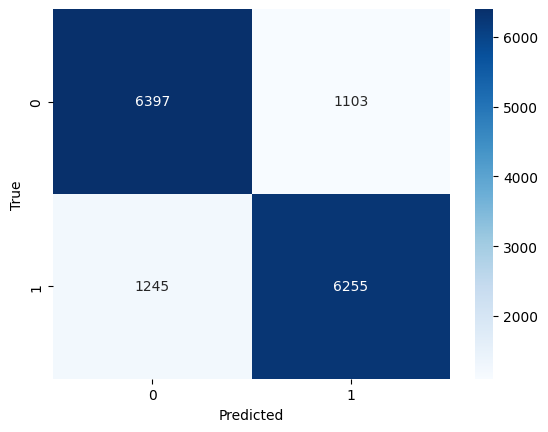

In [21]:
metricas(y_pred_R_M,y_test)

## Voting

In [22]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

0.8689333333333333
              precision    recall  f1-score   support

           0       0.86      0.87      0.87      7398
           1       0.88      0.86      0.87      7602

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



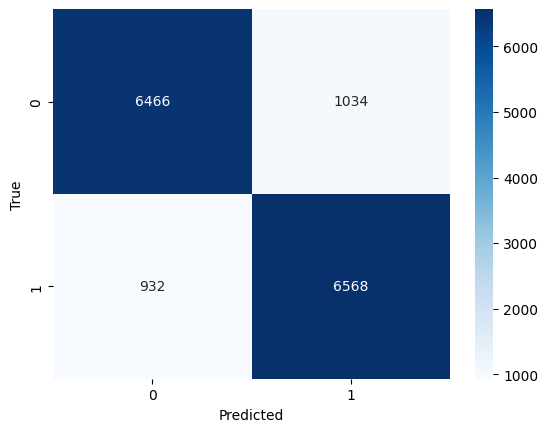

In [32]:
#Creo clasificadores
nb_clf = nb_model
xgb_H_clf = xg_model
rnd_clf = R_f


#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('xgb', xgb_H_clf), ('rnd', rnd_clf), ('nb', nb_clf)], voting = 'hard')

#Armo conjunto entrenamiento y test 80-20
x_train_Vt, x_test_Vt, y_train_Vt, y_test_Vt = train_test_split(df_train_x, 
                                                    df_train_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2,
                                                    stratify=df_train_y.values)


#Entreno el ensemble
vot_clf.fit(x_train_Vt, y_train_Vt)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test_Vt)
print(accuracy_score(y_test_Vt, pred))
metricas(pred,y_test_Vt)

## Red Neuronal

In [14]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# Tokenizar los datos de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1

# Convertir los textos en secuencias numéricas
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Asegurarse de que todas las secuencias tengan la misma longitud
max_seq_length = max(len(seq) for seq in x_train_seq)
x_train_seq = pad_sequences(x_train_seq, maxlen=max_seq_length)
x_test_seq = pad_sequences(x_test_seq, maxlen=max_seq_length)

Buscamos los mejores hiperparametros

In [16]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define a function to build the neural network model with variable epochs
def create_model(epochs=1, num_units=64, learning_rate=0.001):
    model = keras.Sequential([
            layers.Embedding(vocab_size, 100, input_length=max_seq_length),
            layers.Conv1D(128, 5, activation='relu'),
            layers.GlobalMaxPooling1D(),
            layers.Dense(num_units, activation='relu'),
            layers.Dense(1, activation='sigmoid')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision()])
    return model

# Create the KerasClassifier for use in scikit-learn
model = KerasClassifier(build_fn=create_model, batch_size=16)

# Define the hyperparameter grid to search over
param_grid = {
    'epochs': [3],
    'num_units': [64,128,32],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_result = grid_search.fit(x_train_seq, y_train)

# Get the best hyperparameters and the best model
best_params = grid_result.best_params_
best_model = grid_result.best_estimator_



2188/2188 [==============================] - 1717s 783ms/step - loss: 0.3588 - accuracy: 0.8340 - precision: 0.8385


In [17]:
print(best_params)

{'epochs': 1, 'learning_rate': 0.001, 'num_units': 32}


469/469 [==============================] - 63s 134ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      7500
           1       0.88      0.89      0.88      7500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



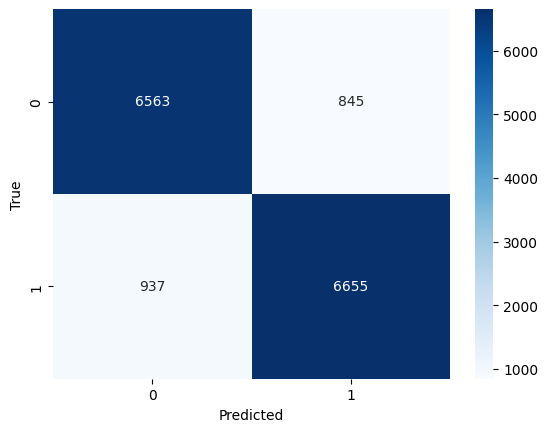

In [18]:
y_predic_ = best_model.predict(x_test_seq)
y_predic_cat = np.where(y_predic_>0.4,1,0) #Seteamos un corte en los datos para determinar si cancelo o no 

ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index() #Armamos un dataset
ds_validacion.columns=['y_pred','y_real'] #Nombramos las columnas

metricas(ds_validacion.y_pred,ds_validacion.y_real) #Dividimos el dataset

Cambio los epochs para mejorar el resultado

In [26]:
# Tokenizar los datos de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
vocab_size = len(tokenizer.word_index) + 1

# Convertir los textos en secuencias numéricas
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Asegurarse de que todas las secuencias tengan la misma longitud
max_seq_length = max(len(seq) for seq in x_train_seq)
x_train_seq = pad_sequences(x_train_seq, maxlen=max_seq_length)
x_test_seq = pad_sequences(x_test_seq, maxlen=max_seq_length)

# Construir el modelo de red neuronal
model = keras.Sequential([
    layers.Embedding(vocab_size, 100, input_length=max_seq_length),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',keras.metrics.Precision()])

# Entrenar el modelo
history = model.fit(x_train_seq, y_train, epochs=4, batch_size=16, validation_data=(x_test_seq, y_test))

Epoch 1/4
2188/2188 [==============================] - 1128s 515ms/step - loss: 0.3607 - accuracy: 0.8335 - precision_2: 0.8354 - val_loss: 0.2842 - val_accuracy: 0.8790 - val_precision_2: 0.8585
Epoch 2/4
2188/2188 [==============================] - 1257s 574ms/step - loss: 0.0973 - accuracy: 0.9673 - precision_2: 0.9664 - val_loss: 0.3362 - val_accuracy: 0.8771 - val_precision_2: 0.8992
Epoch 3/4
2188/2188 [==============================] - 1231s 563ms/step - loss: 0.0088 - accuracy: 0.9982 - precision_2: 0.9980 - val_loss: 0.4241 - val_accuracy: 0.8802 - val_precision_2: 0.8712
Epoch 4/4
2188/2188 [==============================] - 1224s 559ms/step - loss: 8.0225e-04 - accuracy: 0.9999 - precision_2: 0.9998 - val_loss: 0.5413 - val_accuracy: 0.8825 - val_precision_2: 0.8789


469/469 [==============================] - 63s 135ms/step
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      7500
           1       0.87      0.89      0.88      7500

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



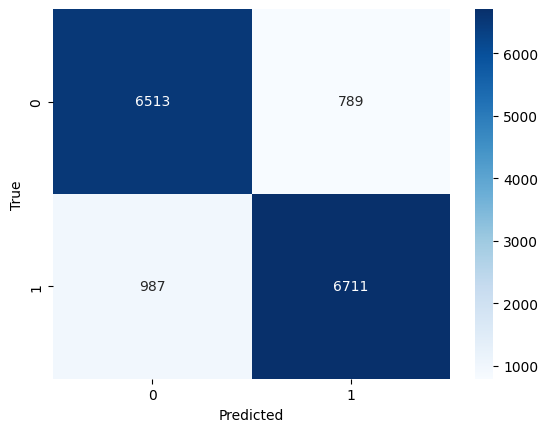

In [27]:
y_predic_ = model.predict(x_test_seq)
y_predic_cat = np.where(y_predic_>0.4,1,0) #Seteamos un corte en los datos para determinar si cancelo o no 

ds_validacion=pd.DataFrame(y_predic_cat,y_test).reset_index() #Armamos un dataset
ds_validacion.columns=['y_pred','y_real'] #Nombramos las columnas

metricas(ds_validacion.y_pred,ds_validacion.y_real) #Dividimos el dataset

In [28]:
f1 = f1_score(ds_validacion.y_real, ds_validacion.y_pred)
print(f1)

0.8831425187524675


## Tratamiento de variables antes del submit

In [34]:
df_test = pd.read_csv('test.csv')
df_copy_id_test = df_test['ID'] #copio el id y lo quito del dataframe
df_test.drop(['ID'], axis='columns', inplace=True)
df_test.head(5)

,review_es
0,La mayor virtud de esta película es su existen...
1,"No soy un experto cinéfilo, pero pocas veces m..."
2,Si no eres un incondicional del humor estilo T...
3,"No sé qué está pasando, si la gente se deja ll..."
4,"Pero cuando amanece,y me quedo solo,siento en ..."


In [35]:
#Paso los objects a strings y reviso los datos faltantes
df_test['review_es'] = df_test['review_es'].astype('string')
datos_faltantes_test = df_test.isnull().sum()
print(datos_faltantes_test)

review_es    0
dtype: int64


In [36]:
df_test['review_es'].value_counts()

review_es
La mayor virtud de esta película es su existen...    1
Pocos fenómenos tan llamativos como esta modes...    1
No sé qué está pasando, si la gente se deja ll...    1
Pero cuando amanece,y me quedo solo,siento en ...    1
La llegada de Rafa a Euskadi es como ponerse a...    1
                                                    ..
Me esperaba mucho, pero que mucho, más.Guión m...    1
De mal cuerpo como sensación al finalizar, de ...    1
Los que han añadido comentarios os lo han dich...    1
Dirigida por Alberto Rodríguez ("Grupo 7"), el...    1
Fui a ver esta película de cine con entusiasmo...    1
Name: count, Length: 8599, dtype: Int64

In [37]:
df_test["review_es"] = df_test["review_es"].apply(lambda x: nltk_preprocess(x))
df_test['review_es'] = df_test['review_es'].astype('string')

## Submits

Bayes-naive

In [32]:
y_submi = nb_model.predict(df_test['review_es'])

In [33]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submi})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test.csv',index = False)

Xg-Boost

In [ ]:
y_submit_xg = xg_model.predict(df_test['review_es'])


In [ ]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_xg})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Xg.csv',index = False)

Random-Forest

In [ ]:
y_submit_R_f = R_f.predict(df_test['review_es'])

In [ ]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_R_f})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Rm.csv',index = False)

Voting

In [38]:
y_submit_vtg = vot_clf.predict(df_test['review_es'])

In [ ]:
df_submit_test = pd.DataFrame({'ID': df_copy_id_test,'sentimiento':y_submit_vtg})
df_submit_test['sentimiento'] = np.where(df_submit_test['sentimiento'] == 1, 'positivo', 'negativo')

df_submit_test.to_csv('Submit_test_Vtg.csv',index = False)